# Features Engineering

Our data can be very high dimensional if we consider the number of languages, countries, actors etc. We have only 44k movies, but we have several hundreds on genres, languages and countries, which gives already around 10 millions possibilities. And this is without even looking at the hundreds of thousands of actors and characters. Thus we have to come up with features that can capture signal in the data, without having to do one-hot encoding for each feature.

## Packages

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
# Sparse Matrix
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

## Helpers

In [2]:
CONTINENT_ID = {"North America and Australia": [1,0,0,0,0,0],
"Central and South America": [0,1,0,0,0,0],
"Western Europe": [0,0,1,0,0,0],
"Eastern Europe and Russia": [0,0,0,1,0,0],
"Africa and Middle-East": [0,0,0,0,1,0],
"Asia": [0,0,0,0,0,1]}

COUNTRY_CONTINENT_MAPPING = {
'afghanistan' : "Africa and Middle-East",
 'albania' : "Eastern Europe and Russia",
 'algeria' : "Africa and Middle-East",
 'argentina': "Central and South America",
 'armenia' : "Africa and Middle-East",
 'aruba': "Central and South America",
 'australia': "North America and Australia",
 'austria': "Western Europe",
 'azerbaijan' : "Africa and Middle-East",
 'bahamas': "Central and South America",
 'bahrain' : "Africa and Middle-East",
 'bangladesh': "Asia",
 'belgium': "Western Europe",
 'bhutan': "Asia",
 'bolivia': "Central and South America",
 'bosnia and herzegovina' : "Eastern Europe and Russia",
 'brazil': "Central and South America",
 'bulgaria' : "Eastern Europe and Russia",
 'burkina faso' : "Africa and Middle-East",
 'burma': "Asia",
 'cambodia': "Asia",
 'cameroon' : "Africa and Middle-East",
 'canada': "North America and Australia",
 'chile': "Central and South America",
 'china': "Asia",
 'colombia': "Central and South America",
 'congo' : "Africa and Middle-East",
 'costa rica': "Central and South America",
 'crime' : "Eastern Europe and Russia",
 'croatia' : "Eastern Europe and Russia",
 'cuba': "Central and South America",
 'cyprus' : "Eastern Europe and Russia",
 'czech republic' : "Eastern Europe and Russia",
 'czechoslovakia' : "Eastern Europe and Russia",
 'democratic republic of the congo' : "Africa and Middle-East",
 'denmark': "Western Europe",
 'egypt' : "Africa and Middle-East",
 'estonia' : "Eastern Europe and Russia",
 'ethiopia' : "Africa and Middle-East",
 'finland': "Western Europe",
 'france': "Western Europe",
 'georgia' : "Africa and Middle-East",
 'germany': "Western Europe",
 'greece' : "Eastern Europe and Russia",
 'haiti': "Central and South America",
 'hong kong': "Asia",
 'hungary' : "Eastern Europe and Russia",
 'iceland': "Western Europe",
 'india': "Asia",
 'indonesia': "Asia",
 'iran' : "Africa and Middle-East",
 'iraq' : "Africa and Middle-East",
 'iraqi kurdistan' : "Africa and Middle-East",
 'ireland': "Western Europe",
 'isle of man': "Western Europe",
 'israel' : "Africa and Middle-East",
 'italy': "Western Europe",
 'jamaica': "Central and South America",
 'japan': "Asia",
 'jordan' : "Africa and Middle-East",
 'kenya' : "Africa and Middle-East",
 'korea': "Asia",
 'kuwait' : "Africa and Middle-East",
 'lebanon' : "Africa and Middle-East",
 'libya' : "Africa and Middle-East",
 'lithuania' : "Eastern Europe and Russia",
 'luxembourg': "Western Europe",
 'macau': "Asia",
 'malaysia': "Asia",
 'mali' : "Africa and Middle-East",
 'malta': "Western Europe",
 'mexico': "Central and South America",
 'monaco': "Western Europe",
 'mongolia': "Asia",
 'montenegro' : "Eastern Europe and Russia",
 'morocco' : "Africa and Middle-East",
 'nepal': "Asia",
 'netherlands': "Western Europe",
 'new zealand': "North America and Australia",
 'nigeria' : "Africa and Middle-East",
 'norway': "Western Europe",
 'pakistan' : "Africa and Middle-East",
 'palestinian territories' : "Africa and Middle-East",
 'panama': "Central and South America",
 'peru': "Central and South America",
 'philippines': "Asia",
 'poland' : "Eastern Europe and Russia",
 'portugal': "Western Europe",
 'puerto rico': "Central and South America",
 'republic of macedonia' : "Eastern Europe and Russia",
 'romania' : "Eastern Europe and Russia",
 'russia' : "Eastern Europe and Russia",
 'senegal' : "Africa and Middle-East",
 'serbia' : "Eastern Europe and Russia",
 'serbia and montenegro' : "Eastern Europe and Russia",
 'singapore': "Asia",
 'slovakia' : "Eastern Europe and Russia",
 'slovenia' : "Eastern Europe and Russia",
 'south africa' : "Africa and Middle-East",
 'south korea': "Asia",
 'spain': "Western Europe",
 'sri lanka': "Asia",
 'sweden': "Western Europe",
 'switzerland': "Western Europe",
 'taiwan': "Asia",
 'thailand': "Asia",
 'tunisia' : "Africa and Middle-East",
 'turkey' : "Africa and Middle-East",
 'ukraine' : "Eastern Europe and Russia",
 'united arab emirates' : "Africa and Middle-East",
 'united kingdom': "Western Europe",
 'united states of america': "North America and Australia",
 'uruguay': "Central and South America",
 'uzbekistan' : "Africa and Middle-East",
 'venezuela': "Central and South America",
 'vietnam': "Asia",
 'yugoslavia' : "Eastern Europe and Russia",
 'zambia' : "Africa and Middle-East",
 'zimbabwe' : "Africa and Middle-East"
}

COUNTRY_ENCODING = { 
    "North America and Australia": [1,0,0,0,0,0],
    "Western Europe":              [0,1,0,0,0,0],
    "Asia":                        [0,0,1,0,0,0],
    "Africa and Middle-East":      [0,0,0,1,0,0],
    "Eastern Europe and Russia":   [0,0,0,0,1,0],
    "Central and South America":   [0,0,0,0,0,1]
}

CONTINENT_LIST = ["North America and Australia","Western Europe","Asia",
                  "Africa and Middle-East","Eastern Europe and Russia", 
                  "Central and South America"]

GENRE_MAPPING = {'absurdism': ["comedy"],
 'acid western': ["adventure","action"],
 'action': ["action"],
 'action comedy': ["action","comedy"],
 'action thrillers': ["thriller","action"],
 'action/adventure': ["action","adventure"],
 'addiction drama': ["drama"],
 'adult': ["adult"],
 'adventure': ["adventure"],
 'adventure comedy': ["adventure","comedy"],
 'airplanes and airports': ["other"],
 'albino bias': ["drama"],
 'alien film': ["action","adventure"],
 'alien invasion': ["action"],
 'americana': ["drama"],
 'animal picture': ["other"],
 'animals': ["other"],
 'animated cartoon': ["animation"],
 'animated musical': ["animation"],
 'animation': ["animation"],
 'anime': ["animation"],
 'anthology': ["genre"],
 'anthropology': ["other"],
 'anti-war': ["drama"],
 'anti-war film': ["drama"],
 'apocalyptic and post-apocalyptic fiction': ["action","fantasy"],
 'archaeology': ["other"],
 'archives and records': ["other"],
 'art film': ["genre"],
 'auto racing': ["other"],
 'avant-garde': ["genre"],
 'b-movie': ["comedy"],
 'b-western': ["action","comedy"],
 'backstage musical': ["other"],
 'baseball': ["other"],
 'beach film': ["other"],
 'beach party film': ["comedy"],
 'bengali cinema': ["other"],
 'biker film':["action"],
 'biographical film': ["other"],
 'biography': ["other"],
 'biopic [feature]': ["other"],
 'black comedy': ["comedy"],
 'black-and-white': ["other"],
 'blaxploitation':["drama"],
 'bloopers & candid camera': ["comedy"],
 'bollywood': ["other"],
 'boxing': ["other"],
 'breakdance': ["other"],
 'british empire film': ["other"],
 'british new wave': ["genre"],
 'bruceploitation':["action"],
 'buddy cop': ["action","comedy"],
 'buddy film': ["comedy"],
 'buddy picture': ["comedy"],
 'business': ["other"],
 'camp': ["other"],
 'caper story': ["thriller"],
 'cavalry film': ["action"],
 'chase movie': ["thriller"],
 'childhood drama': ["drama"],
 "children's": ["family"],
 "children's entertainment": ["family"],
 "children's fantasy": ["family","fantasy"],
 "children's issues": ["drama"],
 "children's/family": ["family"],
 'chinese movies': ["other"],
 'christian film': ["other"],
 'christmas movie': ["other"],
 'clay animation': ["animation"],
 'cold war': ["adventure","action"],
 'combat films': ["action"],
 'comdedy': ["comedy"],
 'comedy': ["comedy"],
 'comedy film': ["comedy"],
 'comedy horror': ["horror","comedy"],
 'comedy of errors': ["comedy"],
 'comedy of manners': ["comedy"],
 'comedy thriller': ["thriller","comedy"],
 'comedy western': ["action","comedy"],
 'comedy-drama': ["drama","comedy"],
 'coming of age': ["comedy"],
 'coming-of-age film': ["comedy"],
 'computer animation': ["animation"],
 'computers': ["animation"],
 'concert film': ["other"],
 'conspiracy fiction': ["thriller"],
 'costume adventure': ["adventure"],
 'costume drama': ["drama"],
 'costume horror': ["horror"],
 'courtroom comedy': ["comedy"],
 'courtroom drama': ["drama"],
 'creature film': ["adventure","fantasy"],
 'crime': ["thriller"],
 'crime comedy': ["thriller","comedy"],
 'crime drama': ["thriller","drama"],
 'crime fiction': ["thriller"],
 'crime thriller': ["thriller"],
 'cult': ["other"],
 'culture & society': ["other"],
 'cyberpunk': ["fantasy"],
 'czechoslovak new wave': ["genre"],
 'dance': ["other"],
 'demonic child': ["horror"],
 'detective': ["thriller"],
 'detective fiction': ["thriller"],
 'disaster': ["drama"],
 'docudrama': ["drama"],
 'documentary': ["other"],
 'dogme 95': ["genre"],
 'domestic comedy': ["comedy"],
 'doomsday film': ["fantasy"],
 'drama': ["drama"],
 'dystopia': ["drama","fantasy"],
 'ealing comedies': ["comedy"],
 'early black cinema': ["other"],
 'education': ["family"],
 'educational': ["family"],
 'ensemble film': ["genre"],
 'environmental science': ["other"],
 'epic': ["adventure"],
 'epic western': ["adventure","action"],
 'erotic drama': ["adult","drama"],
 'erotic thriller': ["thriller","adult"],
 'erotica': ["adult"],
 'escape film': ["thriller"],
 'essay film': ["genre"],
 'existentialism': ["genre"],
 'experimental film': ["genre"],
 'exploitation': ["drama"],
 'expressionism': ["genre"],
 'extreme sports': ["other"],
 'fairy tale': ["fantasy","adventure"],
 'family & personal relationships': ["drama"],
 'family drama': ["drama"],
 'family film': ["family"],
 'family-oriented adventure': ["family","adventure"],
 'fan film': ["other"],
 'fantasy': ["fantasy"],
 'fantasy adventure': ["fantasy","adventure"],
 'fantasy comedy': ["fantasy","comedy"],
 'fantasy drama': ["fantasy","drama"],
 'feature film': ["other"],
 'female buddy film': ["comedy"],
 'feminist film': ["drama"],
 'fictional film': ["other"],
 'filipino': ["other"],
 'filipino movies': ["other"],
 'film': ["other"],
 'film & television history': ["other"],
 'film adaptation': ["other"],
 'film noir': ["thriller"],
 'film à clef': ["drama"],
 'film-opera': ["other"],
 'filmed play': ["other"],
 'finance & investing': ["other"],
 'foreign legion':["action"],
 'future noir': ["fantasy","drama"],
 'gangster film': ["thriller","action"],
 'gay': ["drama"],
 'gay interest': ["drama"],
 'gay pornography': ["adult"],
 'gay themed': ["drama"],
 'gender issues': ["drama"],
 'giallo': ["thriller"],
 'glamorized spy film': ["thriller"],
 'goat gland': ["genre"],
 'gothic film': ["genre"],
 'graphic & applied arts': ["genre"],
 'gross out': ["comedy"],
 'gross-out film': ["comedy"],
 'gulf war':["action"],
 'hagiography': ["other"],
 'hardcore pornography': ["adult"],
 'haunted house film': ["horror"],
 'health & fitness': ["other"],
 'heaven-can-wait fantasies': ["fantasy"],
 'heavenly comedy': ["comedy"],
 'heist': ["action"],
 'hip hop movies': ["other"],
 'historical documentaries': ["other"],
 'historical drama': ["drama"],
 'historical epic': ["adventure"],
 'historical fiction': ["other"],
 'history': ["other"],
 'holiday film': ["comedy"],
 'horror': ["horror"],
 'horror comedy': ["horror","comedy"],
 'horse racing': ["other"],
 'humour': ["comedy"],
 'hybrid western': ["adventure","action"],
 'illnesses & disabilities': ["drama"],
 'indian western': ["adventure","action"],
 'indie': ["genre"],
 'inspirational drama': ["drama"],
 'instrumental music': ["other"],
 'interpersonal relationships': ["drama"],
 'inventions & innovations': ["other"],
 'japanese movies': ["other"],
 'journalism': ["other"],
 'jukebox musical': ["other"],
 'jungle film': ["adventure"],
 'juvenile delinquency film': ["drama"],
 'kafkaesque': ["genre"],
 'kitchen sink realism': ["genre"],
 'language & literature': ["genre"],
 'latino': ["other"],
 'law & crime': ["thriller"],
 'legal drama': ["drama"],
 'lgbt': ["drama"],
 'libraries and librarians': ["other"],
 'live action': ["other"],
 'malayalam cinema': ["other"],
 'marriage drama': ["drama"],
 'martial arts film': ["action"],
 'master criminal films': ["thriller"],
 'media satire': ["other"],
 'media studies': ["other"],
 'medical fiction': ["other"],
 'melodrama': ["drama"],
 'mockumentary': ["other"],
 'mondo film': ["genre"],
 'monster': ["horror","action"],
 'monster movie': ["horror","action"],
 'movie serial': ["other"],
 'movies about gladiators': ["other"],
 'mumblecore': ["genre"],
 'music': ["other"],
 'musical': ["other"],
 'musical comedy': ["comedy"],
 'musical drama': ["drama"],
 'mystery': ["thriller"],
 'mythological fantasy': ["fantasy"],
 'natural disaster': ["other"],
 'natural horror films': ["horror"],
 'nature': ["other"],
 'neo-noir': ["thriller"],
 'neorealism': ["genre"],
 'new hollywood': ["genre"],
 'new queer cinema': ["drama"],
 'news': ["other"],
 'ninja movie': ["action"],
 'northern': ["genre"],
 'operetta': ["other"],
 'outlaw': ["other"],
 'outlaw biker film': ["other"],
 'parkour in popular culture': ["action"],
 'parody': ["comedy"],
 'patriotic film': ["other"],
 'period horror': ["horror"],
 'period piece': ["drama"],
 'pinku eiga': ["adult"],
 'plague': ["drama"],
 'point of view shot': ["other"],
 'political cinema': ["other"],
 'political documetary': ["other"],
 'political drama': ["drama"],
 'political satire': ["drama"],
 'political thriller': ["thriller"],
 'pornographic movie': ["adult"],
 'pornography': ["adult"],
 'pre-code': ["other"],
 'prison': ["action"],
 'prison escape': ["action"],
 'prison film': ["action"],
 'private military company': ["action"],
 'propaganda film': ["other"],
 'psycho-biddy': ["horror","thriller"],
 'psychological horror': ["horror"],
 'psychological thriller': ["thriller"],
 'punk rock': ["genre"],
 'race movie': ["action"],
 'reboot': ["other"],
 'religious film': ["other"],
 'remake': ["other"],
 'revenge': ["action"],
 'revisionist fairy tale': ["adventure","fantasy"],
 'revisionist western': ["adventure","action"],
 'road movie': ["other"],
 'road-horror': ["horror"],
 'roadshow theatrical release': ["other"],
 'roadshow/carny': ["other"],
 'rockumentary': ["other"],
 'romance film': ["other"],
 'romantic comedy': ["comedy"],
 'romantic drama': ["drama"],
 'romantic fantasy': ["fantasy"],
 'romantic thriller': ["thriller"],
 'samurai cinema': ["adventure","action"],
 'satire': ["comedy"],
 'school story': ["family"],
 'sci-fi adventure': ["fantasy","adventure"],
 'sci-fi horror': ["fantasy","horror"],
 'sci-fi thriller': ["fantasy","thriller"],
 'science fiction': ["fantasy"],
 'science fiction western': ["adventure","fantasy","action"],
 'screwball comedy': ["comedy"],
 'sex comedy': ["comedy"],
 'sexploitation': ["drama"],
 'short film': ["other"],
 'silent film': ["other"],
 'singing cowboy': ["action","adventure"],
 'slapstick': ["comedy"],
 'slasher': ["horror","action"],
 'slice of life story': ["drama"],
 'social issues': ["drama"],
 'social problem film': ["drama"],
 'softcore porn': ["adult"],
 'space opera': ["fantasy","adventure"],
 'space western': ["adventure","action"],
 'spaghetti western': ["adventure","action"],
 'splatter film': ["horror"],
 'sports': ["other"],
 'spy': ["thriller"],
 'stand-up comedy': ["comedy"],
 'star vehicle': ["other"],
 'steampunk': ["fantasy"],
 'stoner film': ["genre"],
 'stop motion': ["animation"],
 'superhero': ["action"],
 'superhero movie': ["action"],
 'supermarionation': ["animation"],
 'supernatural': ["fantasy"],
 'surrealism': ["genre"],
 'suspense': ["thriller"],
 'swashbuckler films': ["action","adventure"],
 'sword and sandal': ["adventure"],
 'sword and sorcery': ["fantasy","adventure"],
 'sword and sorcery films': ["fantasy","adventure"],
 'tamil cinema': ["other"],
 'teen': ["family"],
 'television movie': ["other"],
 'the netherlands in world war ii': ["action"],
 'therimin music': ["other"],
 'thriller': ["thriller"],
 'time travel': ["adventure"],
 'tokusatsu': ["other"],
 'tollywood': ["other"],
 'tragedy': ["drama"],
 'tragicomedy': ["comedy"],
 'travel': ["adventure"],
 'vampire movies': ["horror","action"],
 'war effort': ["action"],
 'war film': ["action"],
 'werewolf fiction': ["horror"],
 'western': ["adventure","action"],
 'whodunit': ["thriller"],
 'women in prison films': ["drama"],
 'workplace comedy': ["comedy"],
 'world cinema': ["other"],
 'world history': ["other"],
 'wuxia': ["adventure"],
 'z movie': ["horror"],
 'zombie film': ["horror"]}

GENRE_ENCODING = {
    "action":    [1,0,0,0,0,0,0,0,0,0,0],
    "adventure": [0,1,0,0,0,0,0,0,0,0,0],
    "comedy":    [0,0,1,0,0,0,0,0,0,0,0],
    "drama":     [0,0,0,1,0,0,0,0,0,0,0],
    "thriller":  [0,0,0,0,1,0,0,0,0,0,0],
    "horror":    [0,0,0,0,0,1,0,0,0,0,0],
    "animation": [0,0,0,0,0,0,1,0,0,0,0],
    "family":    [0,0,0,0,0,0,0,1,0,0,0],
    "adult":     [0,0,0,0,0,0,0,0,1,0,0],
    "fantasy":   [0,0,0,0,0,0,0,0,0,1,0],
    "genre":     [0,0,0,0,0,0,0,0,0,0,1],
    "other":     [0,0,0,0,0,0,0,0,0,0,0]
}

GENRE_LIST = ["action","adventure","comedy","drama","thriller","horror",
                   "animation","children","adult","fantasy","genre"]

LANGUAGE_FAMILY_MAPPING = {
'aboriginal malays': "Austronesian",
 'afrikaans': "Indo-European",
 'akan': "Atlantic–Congo",
 'albanian': "Indo-European",
 'algonquin': "Unclassified Language",
 'amharic': "Afro-Asiatic",
 'ancient egyptian': "Indo-European",
 'ancient greek': "Indo-European",
 'apache, western': "Unclassified Language",
 'arabic': "Afro-Asiatic",
 'aramaic': "Afro-Asiatic",
 'armenian': "Indo-European",
 'assamese': "Indo-European",
 'assyrian': "Afro-Asiatic",
 'awadhi': "Indo-European",
 'azerbaijani': "Altaic",
 'bambara': "Atlantic–Congo",
 'belarusian': "Indo-European",
 'bengali': "Indo-European",
 'bhojpuri': "Indo-European",
 'bosnian': "Indo-European",
 'brazilian portuguese': "Indo-European",
 'bulgarian': "Indo-European",
 'burmese': "Sino-Tibetan",
 'cantonese': "Sino-Tibetan",
 'catalan': "Indo-European",
 'cebuano': "Austronesian",
 'chadian arabic': "Afro-Asiatic",
 'chechen': "Indo-European",
 'chewa': "Atlantic–Congo",
 'cheyenne': "Unclassified Language",
 'chinese': "Sino-Tibetan",
 'chinese, hakka': "Sino-Tibetan",
 'chinese, jinyu': "Sino-Tibetan",
 'corsican': "Indo-European",
 'cree': "Unclassified Language",
 'croatian': "Indo-European",
 'crow': "Unclassified Language",
 'czech': "Indo-European",
 'danish': "Indo-European",
 'dari': "Indo-European",
 'deutsch': "Indo-European",
 'dutch': "Indo-European",
 'dzongkha': "Sino-Tibetan",
 'egyptian arabic': "Afro-Asiatic",
 'english': "Indo-European",
 'esperanto': "Unclassified Language",
 'estonian': "Indo-European",
 'farsi': "Indo-European",
 'filipino': "Austronesian",
 'finnish': "Indo-European",
 'flemish': "Indo-European",
 'french': "Indo-European",
 'fula': "Atlantic–Congo",
 'fulfulde, adamawa': "Atlantic–Congo",
 'gaelic': "Indo-European",
 'galician': "Indo-European",
 'georgian': "Unclassified Language",
 'german': "Indo-European",
 'greek': "Indo-European",
 'guanzhong hua': "Sino-Tibetan",
 'gujarati': "Indo-European",
 'gumatj': "Unclassified Language",
 'hainanese': "Sino-Tibetan",
 'hariyani': "Indo-European",
 'haryanvi': "Indo-European",
 'hausa': "Afro-Asiatic",
 'hawaiian': "Austronesian",
 'hazaragi': "Indo-European",
 'hebrew': "Afro-Asiatic",
 'hiligaynon': "Austronesian",
 'hindi': "Indo-European",
 'hindustani': "Indo-European",
 'hinglish': "Indo-European",
 'hmong': "Sino-Tibetan",
 'hokkien': "Sino-Tibetan",
 'hopi': "Unclassified Language",
 'hungarian': "Indo-European",
 'hungary': "Indo-European",
 'icelandic': "Indo-European",
 'indonesian': "Austronesian",
 'inuktitut': "Unclassified Language",
 'irish': "Indo-European",
 'italian': "Indo-European",
 'japan': "Altaic",
 'japanese': "Altaic",
 'judeo-georgian': "Unclassified Language",
 'kannada': "Dravidian",
 'khmer': "Austronesian",
 'kinyarwanda': "Atlantic–Congo",
 'klingon': "Unclassified Language",
 'korean': "Altaic",
 'krio': "Indo-European",
 'kurdish': "Indo-European",
 'latin': "Indo-European",
 'lithuanian': "Indo-European",
 'luxembourgish': "Indo-European",
 'macedonian': "Indo-European",
 'malay': "Austronesian",
 'malayalam': "Dravidian",
 'mandarin': "Sino-Tibetan",
 'maninka': "Atlantic–Congo",
 'marathi': "Indo-European",
 'maya, yucatán': "Unclassified Language",
 'mende': "Atlantic–Congo",
 'min nan': "Sino-Tibetan",
 'mohawk': "Unclassified Language",
 'mongolian': "Altaic",
 'māori': "Austronesian",
 'nahuatls': "Unclassified Language",
 'napoletano-calabrese': "Indo-European",
 'navajo': "Unclassified Language",
 'nepali': "Indo-European",
 'norwegian': "Indo-European",
 'old english': "Indo-European",
 'oriya': "Indo-European",
 'palawa kani': "Unclassified Language",
 'papiamento': "Indo-European",
 'pashto': "Indo-European",
 'pawnee': "Unclassified Language",
 'persian': "Indo-European",
 'plautdietsch': "Indo-European",
 'polish': "Indo-European",
 'portuguese': "Indo-European",
 'punjabi': "Indo-European",
 'quechua': "Unclassified Language",
 'rajasthani': "Indo-European",
 'romani': "Indo-European",
 'romanian': "Indo-European",
 'russian': "Indo-European",
 'saami, north': "Indo-European",
 'samis': "Atlantic–Congo",
 'sanskrit': "Indo-European",
 'scanian': "Indo-European",
 'scottish gaelic': "Indo-European",
 'serbian': "Indo-European",
 'serbo-croatian': "Indo-European",
 'shanghainese': "Sino-Tibetan",
 'shanxi': "Sino-Tibetan",
 'sicilian': "Indo-European",
 'sign': "Silent",
 'silent film': "Silent",
 'sinhala': "Indo-European",
 'sioux': "Unclassified Language",
 'slovak': "Indo-European",
 'slovenian': "Indo-European",
 'somali': "Afro-Asiatic",
 'sotho': "Atlantic–Congo",
 'spanish': "Indo-European",
 'sumerian': "Unclassified Language",
 'sunda': "Austronesian",
 'swahili': "Atlantic–Congo",
 'swedish': "Indo-European",
 'swiss german': "Indo-European",
 'tagalog': "Austronesian",
 'taiwanese': "Sino-Tibetan",
 'tamil': "Dravidian",
 'telugu': "Dravidian",
 'teochew': "Sino-Tibetan",
 'thai': "Austronesian",
 'tibetan': "Sino-Tibetan",
 'tibetans': "Sino-Tibetan",
 'tok pisin': "Indo-European",
 'tulu': "Dravidian",
 'turkish': "Indo-European",
 'tuu': "Unclassified Language",
 'tzotzil': "Unclassified Language",
 'ukrainian': "Indo-European",
 'urdu': "Indo-European",
 'venetian': "Indo-European",
 'vietnamese': "Austronesian",
 'welsh': "Indo-European",
 'wolof': "Atlantic–Congo",
 'xhosa': "Atlantic–Congo",
 'yiddish': "Indo-European",
 'yolngu matha': "Austronesian",
 'zulu': "Atlantic–Congo"
}

LANGUAGE_FAMILY_LIST = ["Afro-Asiatic","Altaic","Atlantic–Congo","Austronesian","Dravidian",
                        "Indo-European","Silent","Sino-Tibetan","Unclassified Language"]

LANGUAGUE_ENCODING = {
    "Afro-Asiatic": [1,0,0,0,0,0,0,0,0],
    "Altaic": [0,1,0,0,0,0,0,0,0],
    "Atlantic–Congo": [0,0,1,0,0,0,0,0,0],
    "Austronesian": [0,0,0,1,0,0,0,0,0],
    "Dravidian": [0,0,0,0,1,0,0,0,0],
    "Indo-European": [0,0,0,0,0,1,0,0,0],
    "Silent": [0,0,0,0,0,0,1,0,0],
    "Sino-Tibetan": [0,0,0,0,0,0,0,1,0],
    "Unclassified Language": [0,0,0,0,0,0,0,0,1]
}

# These parameters control the formation of the dataframe for regression
# drop: Columns to drop before applying any transform to the data
# nan_filtering: Columns on which we want to remove rows with nans.
#                If 'all', then apply on every one.
# decades: List of decades on which to apply the regression. 
#          If empty list then all decades will be taken.
# log: Columns on which to apply a log transform.
# standardize: Columns to standardize.
# post_drop: Columns to drop before doing the regression.
DEFAULT_PARAMETERS = {
            "drop": ["name","revenue","has_common_character_name","character_number"],
            "nan_filtering":["all"],
            "decades":[],
            "log":[],
            "standardize":["title_length"],
            "post_drop": ["release_date","num_votes",
                            "runtime","decade","average_rating",
                            "combinned_best_rating"]}

SUCCESS_THRESHOLD = 7.5

NE_FULL_LIST = ["ORGANIZATION","PERSON","LOCATION",
                "DATE","TIME","MONEY",
                "PERCENT","FACILITY","GPE"]

EPSILON = 1e-4 # Set to 1e-4 empirically, but idea is to have at least one occurence in all corpus

## Load Data

In [3]:
country_df = pd.read_pickle("../../data/post_processing//country_df.pkl")
comes_from_df = pd.read_pickle("../../data/post_processing/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/post_processing/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/post_processing/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/post_processing/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/post_processing/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/post_processing/character_df.pkl")
actor_df = pd.read_pickle("../../data/post_processing/actor_df.pkl")
movie_df = pd.read_pickle("../../data/post_processing/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/post_processing/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/post_processing/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/post_processing/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")
is_directed_by_df = pd.read_pickle("../../data/post_processing/is_directed_by_df.pkl")
director_df = pd.read_pickle("../../data/post_processing/director_df.pkl")

## Create Regression DataFrame

In [4]:
movie_regression_df = movie_df.copy()
movie_regression_df.drop(["freebase_id","plot"],axis=1,inplace=True)
movie_regression_df["num_votes"] = movie_regression_df["num_votes"].astype(np.int32)

## Countries

For the countries we can already try to group per continent. It will give an idea of the different local influence without going in too much details. We suggest the following partition based on our previous analyses:

- North America and Australia
- Central and South America
- Western Europe
- Eastern Europe and Russia
- Africa and Middle-East
- Asia

In [5]:
country_movie_df = comes_from_df.copy()
country_movie_df["country_encoding"] = country_movie_df["country_name"].apply(
    lambda c: COUNTRY_CONTINENT_MAPPING[c])
country_movie_df["country_encoding"] = country_movie_df["country_encoding"].apply(
    lambda c: np.array(COUNTRY_ENCODING[c]))
for continent in CONTINENT_LIST:
    country_movie_df[continent] = country_movie_df["country_encoding"].apply(
        lambda l: l[CONTINENT_LIST.index(continent)])
    movie_regression_df[continent] = country_movie_df.groupby("movie_id")[continent].max()

## Actors

For the actors, we thought about the following features:
- #number of actors in the top 5% (or 1% ?)
- #number of actors
- mean actor age
- gender balance

In [6]:
percentile = 99
actor_movie_count = appears_in_df.groupby("actor_id")["movie_id"].count().values
threshold = np.percentile(actor_movie_count,percentile)
is_actor_above_threshold = appears_in_df.groupby("actor_id")["movie_id"].count().sort_index() >= threshold
top_k_actors = actor_df[is_actor_above_threshold.values]
print(f"There are {len(top_k_actors)} actors in the top {percentile}%.")

There are 1014 actors in the top 99%.


In [7]:
actor_movie_df = appears_in_df.merge(actor_df["gender"],how="left",on="actor_id")
actor_movie_df["gender"] = actor_movie_df["gender"].apply(
    lambda g: -1 if g == "M" else 1 if g == "F" else g)
actor_movie_df["is_top_k"] = actor_movie_df["actor_id"].isin(set(top_k_actors.index))

In [8]:
movie_regression_df["actor_number"] = actor_movie_df.groupby("movie_id")["actor_id"].count()
movie_regression_df["mean_actor_age"] = actor_movie_df.groupby("movie_id")["actor_age"].mean()
movie_regression_df["gender_ratio"] = actor_movie_df.groupby("movie_id")["gender"].mean()
movie_regression_df["has_famous_actor"] = actor_movie_df.groupby("movie_id")["is_top_k"].max()
movie_regression_df["has_famous_actor"] = movie_regression_df["has_famous_actor"].replace({True: 1, False: 0})

## Genre

For the genre we suggest the following features:
- #genres
- One-hot-encoding of genre cluster:
    - action
    - adventure
    - comedy
    - drame
    - thriller
    - horror
    - animation
    - children
    - adult
    - fantasy
    - genre
    - other

In [9]:
genre_movie_df = is_of_type_df.copy()
genre_movie_df["genre_encoding"] = genre_movie_df["genre_name"].apply(lambda g: GENRE_MAPPING[g])
genre_movie_df["genre_encoding"] = genre_movie_df["genre_encoding"].apply(
    lambda l: np.sum([np.array(GENRE_ENCODING[g]) for g in l],axis=0))
for genre in GENRE_LIST:
    genre_movie_df[genre] = genre_movie_df["genre_encoding"].apply(
        lambda l: l[GENRE_LIST.index(genre)])
    movie_regression_df[genre] = genre_movie_df.groupby("movie_id")[genre].max()
movie_regression_df["genre_number"] = genre_movie_df.groupby("movie_id")["genre_name"].count()

## Languages

For the languages we can try to group per language family. It will give an idea of the different influence of a common ancestral language without going in too much details. We suggest the following partition based on our previous analysis:
- Afro-Asiatic
- Altaic
- Atlantic–Congo
- Austronesian
- Dravidian
- Indo-European
- Silent
- Sino-Tibetan
- Unclassified Language

In [10]:
language_movie_df = spoken_languages_df.copy()
language_movie_df["language_encoding"] = language_movie_df["language_name"].apply(
    lambda c: LANGUAGE_FAMILY_MAPPING[c])
language_movie_df["language_encoding"] = language_movie_df["language_encoding"].apply(
    lambda c: np.array(LANGUAGUE_ENCODING[c]))
for language_family in LANGUAGE_FAMILY_LIST:
    language_movie_df[language_family] = language_movie_df["language_encoding"].apply(
        lambda l: l[LANGUAGE_FAMILY_LIST.index(language_family)])
    movie_regression_df[language_family] = language_movie_df.groupby("movie_id")[language_family].max()

## Characters
- #characters
- usage of common names

In [11]:
k_characters = 20
top_k_characters_names = set(character_df["character_name"].value_counts().head(k_characters).index)
top_k_characters_ids = set(character_df[character_df["character_name"].isin(top_k_characters_names)].index)
character_movie_df = belongs_to_df.copy()
character_movie_df["common_character_name"] = character_movie_df["character_id"].isin(top_k_characters_ids)
movie_regression_df["has_common_character_name"] = character_movie_df.groupby(
    "movie_id")["common_character_name"].max()
movie_regression_df["character_number"] = character_movie_df.groupby(
    "movie_id")["character_id"].count()
movie_regression_df["has_common_character_name"] = movie_regression_df[
    "has_common_character_name"].replace({True: 1, False: 0})

## Decade

In [12]:
movie_regression_df["decade"] = movie_regression_df["release_date"].apply(lambda d: d.year - d.year%10)

## Movie Title

In [13]:
movie_regression_df["title_length"] = movie_regression_df["name"].apply(lambda n: len(n.split()))

## Genre Analysis

In [14]:
rating_genre = movie_regression_df.filter(GENRE_LIST+["average_rating"])
rating_genre = rating_genre[GENRE_LIST].multiply(rating_genre["average_rating"], axis=0)
rating_genre

,action,adventure,comedy,drama,thriller,horror,animation,children,adult,fantasy,genre
movie_id,,,,,,,,,,,
975900,4.9,4.9,0.0,0.0,4.9,4.9,0.0,0.0,0.0,4.9,0.0
28463795,0.0,0.0,0.0,5.7,5.7,0.0,0.0,0.0,0.0,0.0,0.0
261236,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10408933,0.0,0.0,6.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2345652,0.0,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,7.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3868432,0.0,0.0,0.0,0.0,0.0,6.4,0.0,0.0,0.0,0.0,0.0
15394941,5.8,0.0,5.8,5.8,5.8,0.0,0.0,0.0,0.0,0.0,0.0
23851782,0.0,0.0,6.2,0.0,6.2,0.0,0.0,0.0,0.0,6.2,0.0


In [15]:
sum_rating_genre = pd.merge(rating_genre, movie_regression_df, on="movie_id", suffixes=(None, "_y"))[GENRE_LIST+["decade"]].groupby("decade").sum()

In [16]:
sum_nb_genre = movie_regression_df[GENRE_LIST+["decade"]].groupby("decade").sum()

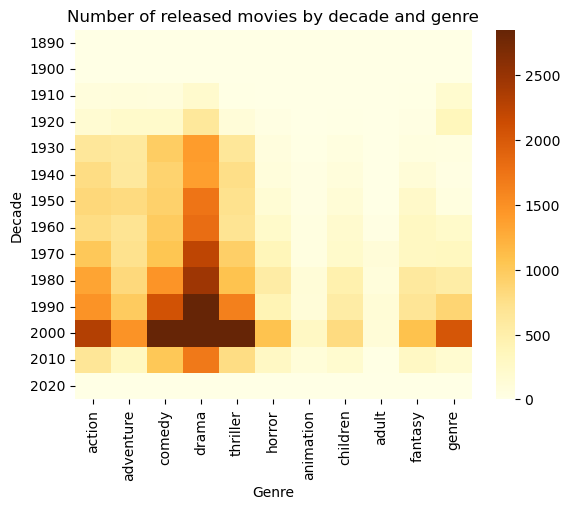

In [17]:
sns.heatmap(sum_nb_genre, robust=True, square=False, cmap="YlOrBr")
plt.title("Number of released movies by decade and genre")
plt.xlabel("Genre")
plt.ylabel("Decade")
plt.show()

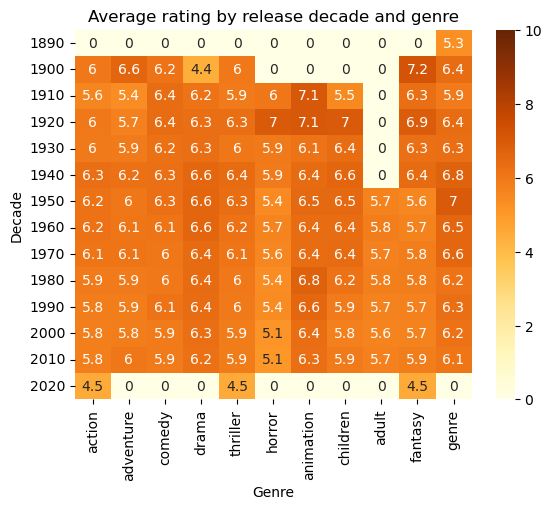

In [18]:
sns.heatmap(sum_rating_genre.divide(sum_nb_genre).fillna(0), robust=False, square=False, annot=True, vmin=0, vmax=10, cmap="YlOrBr")
plt.title("Average rating by release decade and genre")
plt.xlabel("Genre")
plt.ylabel("Decade")
plt.show()